# Course Title: Data Analytics & Statistics in Python  
## Metropolia University of Applied Sciences  
## Week 7: Mini-Project "Crypto Market Analysis (2015–2025)"  
### Date: 23.4.2025  

<table style="width: 100%;">
  <tr>
    <td style="text-align: left; vertical-align: middle;">
      <ul style="list-style: none; padding-left: 0;">
        <li><strong>Instructor</strong>: Hamed Ahmadinia, Ph.D</li>
        <li><strong>Email</strong>: hamed.ahmadinia@metropolia.fi</li>
        <li><strong>Web</strong>: www.ahmadinia.fi</li>
      </ul>
    </td>
  </tr>
</table>

**© 2025 Hamed Ahmadinia – [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)**

In [55]:
# Loading necessary library
import math # For mathematical functions like sqrt(), log(), and constants like pi
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations and working with arrays
import matplotlib.pyplot as plt  # For creating static visualizations
import seaborn as sns  # For statistical data visualization with enhanced aesthetics

from scipy.stats import shapiro, mannwhitneyu, ttest_ind, zscore  # For statistical hypothesis tests: normality and comparing groups

from sklearn.linear_model import LinearRegression  # For performing linear regression modeling
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For evaluating regression model performance

In [57]:
# Step 1: Loading Dataset
file_path = "crypto_market_data_2018_2024.csv"  # Define the file path to the dataset
df = pd.read_csv(file_path)  # Load the dataset into a DataFrame

df['dates'] = pd.to_datetime(df['dates'])  # Convert the 'dates' column to datetime format for time-series analysis

df.head()  # Display the first 5 rows of the DataFrame to inspect the data

,dates,symbol,open,close,high,low,volume,adj_close
0,2018-01-15,TEL-USD,0.004678,0.006031,0.007141,0.004678,842193.0,0.006031
1,2018-01-16,TEL-USD,0.006056,0.004935,0.006077,0.004112,573317.0,0.004935
2,2018-01-17,TEL-USD,0.004989,0.004539,0.005347,0.003257,477139.0,0.004539
3,2018-01-18,TEL-USD,0.004591,0.007200,0.008505,0.004443,15296600.0,0.007200
4,2018-01-19,TEL-USD,0.007133,0.008325,0.008325,0.006071,15603100.0,0.008325


In [58]:
# Step 2a: Check Data Distribution Using Shapiro-Wilk Test

def check_distribution(df):
    distribution_results = {}  # Dictionary to store results for each numeric column

    # Loop through all numeric columns in the DataFrame
    for column in df.select_dtypes(include=['number']).columns:
        try:
            # Apply the Shapiro-Wilk test to a random sample of 5000 non-null values
            stat, p = shapiro(df[column].dropna().sample(n=5000, random_state=42))

            # Interpret the p-value to determine normality
            distribution_results[column] = "Normal Distribution" if p > 0.05 else "Skewed Distribution"
        except:
            # In case the test fails (e.g., not enough data), store a failure message
            distribution_results[column] = "Test Failed"

    return distribution_results  # Return the dictionary with results

# Call the function and store the results
distribution_results = check_distribution(df)

# Print the normality check results
print("Data Distribution Check:\n", distribution_results)

Data Distribution Check:
 {'open': 'Skewed Distribution', 'close': 'Skewed Distribution', 'high': 'Skewed Distribution', 'low': 'Skewed Distribution', 'volume': 'Skewed Distribution', 'adj_close': 'Skewed Distribution'}


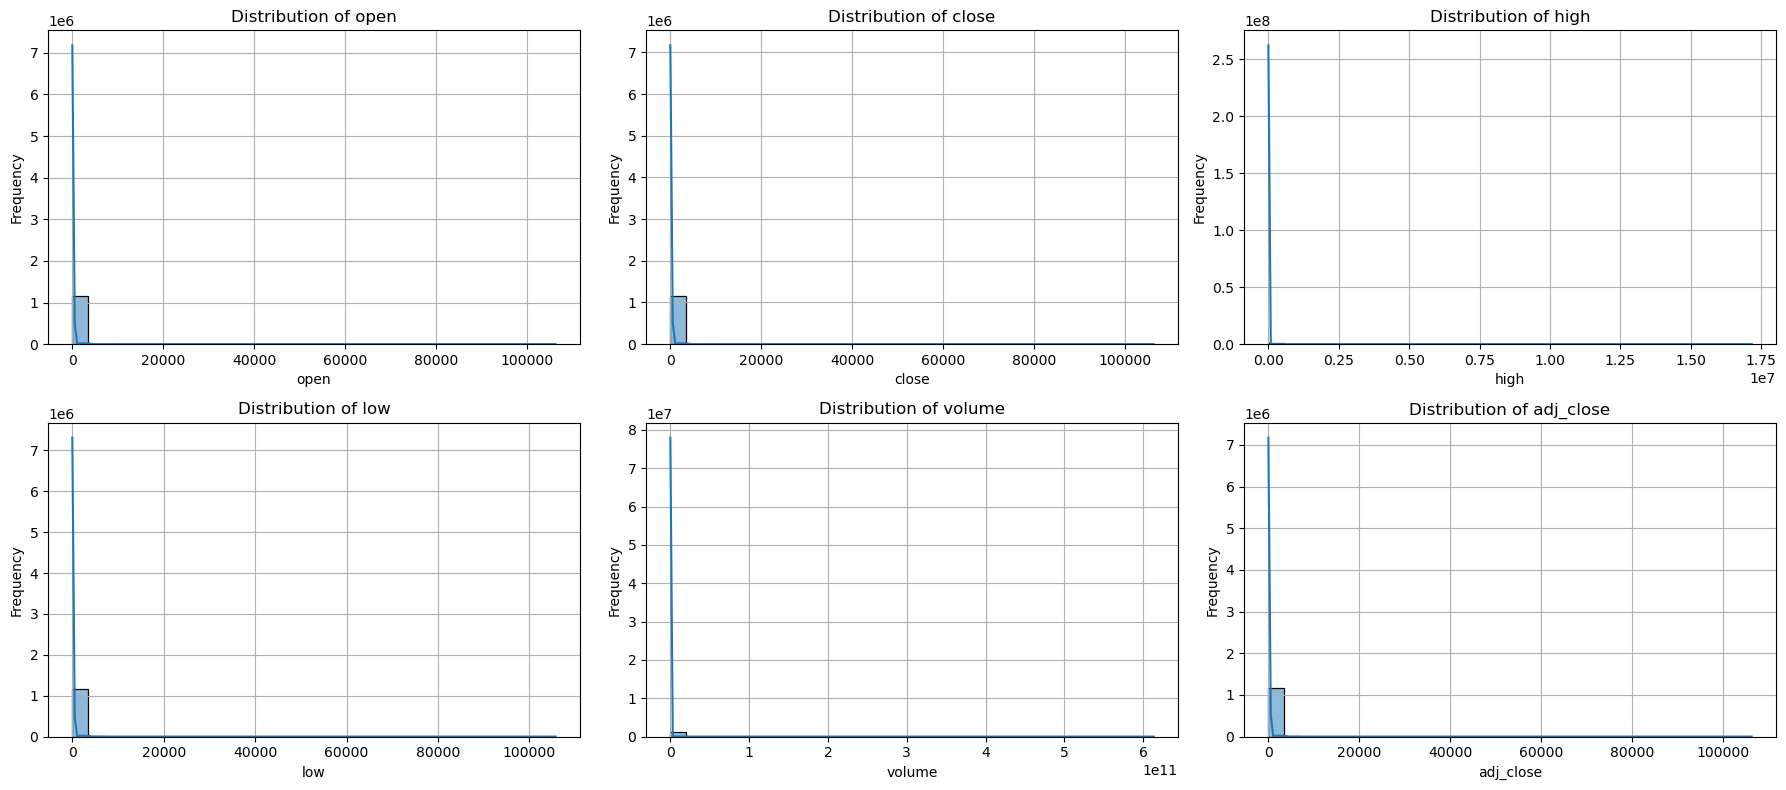

In [59]:
# Step 2b: Visualize data distributions for numeric columns
def plot_distributions_grid(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_cols)
    
    # Determine grid size (e.g., 3 columns)
    cols = 3
    rows = math.ceil(num_cols / cols)

    # Create the big figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function to plot all in one grid
plot_distributions_grid(df)

In [60]:
# Step 3: Recommend Missing Data Imputation Strategy

def recommend_imputation(df, distribution_results):
    recommendations = {}  # Dictionary to store imputation recommendations for each column

    for column in df.columns:
        missing_count = df[column].isnull().sum()
        total_count = len(df)
        missing_percentage = (missing_count / total_count) * 100
        dist = distribution_results.get(column, "Not Checked")
        col_dtype = df[column].dtype

        print(f"\nColumn: {column}")
        print(f"Missing: {missing_count} ({missing_percentage:.2f}%)")
        print(f"Data Type: {col_dtype}")
        print(f"Distribution: {dist}")

        if missing_count == 0:
            print("Recommendation: No missing values")
            recommendations[column] = "No missing values"
            continue

        if col_dtype == 'object' or str(col_dtype) == 'category':
            # Categorical column
            if missing_percentage < 40:
                print("Recommendation: Use Mode Imputation (Categorical)")
                recommendations[column] = "Use Mode Imputation"
            else:
                print("Recommendation: Too many missing values — consider removing")
                recommendations[column] = "Too many missing values — consider removing"
        else:
            # Numeric column
            if missing_percentage < 5:
                print("Recommendation: Use Median Imputation")
                recommendations[column] = "Use Median Imputation"
            elif missing_percentage < 20:
                print("Recommendation: Use KNN Imputation or Median Imputation")
                recommendations[column] = "Use KNN Imputation or Median Imputation"
            elif missing_percentage < 30:
                print("Recommendation: Consider Multiple Imputation (MICE)")
                recommendations[column] = "Consider Multiple Imputation (MICE)"
            elif missing_percentage < 40:
                print("Recommendation: Use Model-Based Imputation")
                recommendations[column] = "Use Model-Based Imputation"
            else:
                print("Recommendation: Too many missing values — consider removing")
                recommendations[column] = "Too many missing values — consider removing"

    return recommendations

# Apply the function
missing_recommendations = recommend_imputation(df, distribution_results)


Column: dates
Missing: 0 (0.00%)
Data Type: datetime64[ns]
Distribution: Not Checked
Recommendation: No missing values

Column: symbol
Missing: 0 (0.00%)
Data Type: object
Distribution: Not Checked
Recommendation: No missing values

Column: open
Missing: 15878 (1.33%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: Use Median Imputation

Column: close
Missing: 15878 (1.33%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: Use Median Imputation

Column: high
Missing: 15878 (1.33%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: Use Median Imputation

Column: low
Missing: 15879 (1.33%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: Use Median Imputation

Column: volume
Missing: 15879 (1.33%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: Use Median Imputation

Column: adj_close
Missing: 15879 (1.33%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: Use Median Imp

Number of outliers detected per column:
 open         5638
close        5639
high         2259
low          5612
volume       4977
adj_close    5639
dtype: int64

--- Summary Statistics ---


,count,mean,std,min,25%,50%,75%,max
open,1176923.0,2.761129e+02,3.685217e+03,0.0,0.017303,0.150836,1.084349e+00,1.063018e+05
close,1176923.0,2.763725e+02,3.689345e+03,0.0,0.017283,0.150644,1.083579e+00,1.063018e+05
high,1176923.0,3.001109e+02,1.643926e+04,0.0,0.018272,0.159213,1.123167e+00,1.716332e+07
low,1176922.0,2.692440e+02,3.602181e+03,0.0,0.016439,0.142990,1.046237e+00,1.057543e+05
volume,1176922.0,1.297373e+08,1.908627e+09,0.0,148144.250000,990772.000000,7.207286e+06,6.131225e+11
adj_close,1176922.0,2.763158e+02,3.689350e+03,0.0,0.017283,0.150644,1.083573e+00,1.063018e+05



 Boxplots to Inspect Outliers:


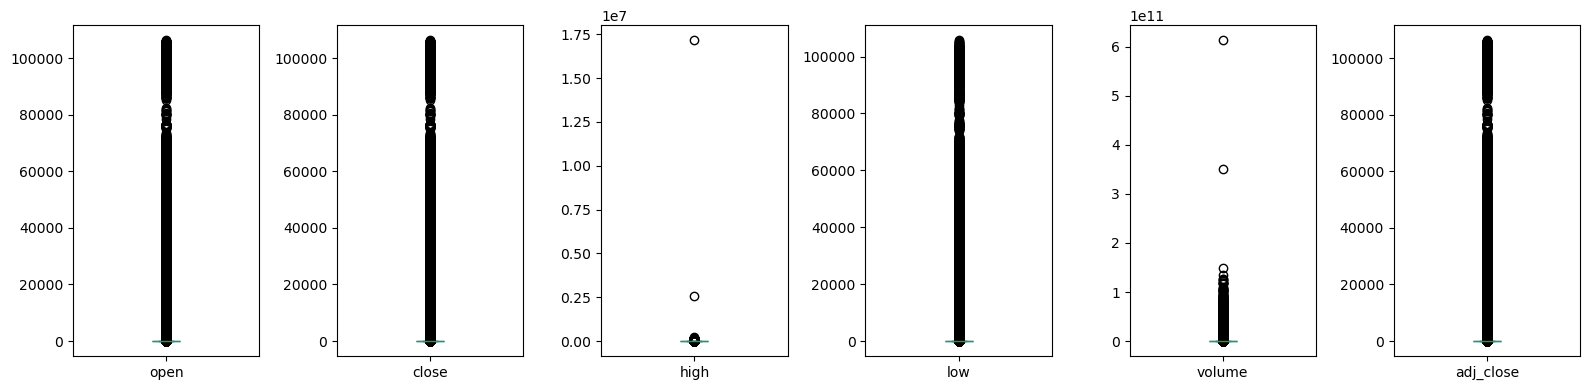

In [61]:
# Step 4: Detect, Report, and Visualize Outliers Using Z-Score

def visualize_outliers(df, threshold=3):
    df_numeric = df.select_dtypes(include=['number'])

    # Calculate Z-scores
    z_scores = df_numeric.apply(zscore, nan_policy='omit')

    # Count how many values are considered outliers
    outlier_counts = (z_scores.abs() > threshold).sum()
    print("Number of outliers detected per column:\n", outlier_counts)

    # Summary statistics
    print("\n--- Summary Statistics ---")
    display(df_numeric.describe().T)

    # Boxplot visualization
    print("\n Boxplots to Inspect Outliers:")
    df_numeric.plot(kind='box', subplots=True, layout=(1, len(df_numeric.columns)), figsize=(16, 4), patch_artist=True)
    plt.tight_layout()
    plt.show()

# Apply outlier visualization
visualize_outliers(df)

In [62]:
# Step 5: Apply Median Imputation Based on Recommendations

# Loop through each column and its recommended imputation method
for col, method in missing_recommendations.items():
    if method == "Use Median Imputation":
        # Replace missing values with the median of the column
        df[col] = df[col].fillna(df[col].median())

# Show the updated DataFrame after applying imputation
print(df.head())  # Display the first few rows to verify changes

       dates   symbol      open     close      high       low      volume  \
0 2018-01-15  TEL-USD  0.004678  0.006031  0.007141  0.004678    842193.0   
1 2018-01-16  TEL-USD  0.006056  0.004935  0.006077  0.004112    573317.0   
2 2018-01-17  TEL-USD  0.004989  0.004539  0.005347  0.003257    477139.0   
3 2018-01-18  TEL-USD  0.004591  0.007200  0.008505  0.004443  15296600.0   
4 2018-01-19  TEL-USD  0.007133  0.008325  0.008325  0.006071  15603100.0   

   adj_close  
0   0.006031  
1   0.004935  
2   0.004539  
3   0.007200  
4   0.008325  


In [63]:
# Step 6: Time-Based Aggregation for All Cryptos

# Group the data by 'symbol' and calculate the average closing price for each cryptocurrency
daily_avg_all = (
    df.groupby('symbol')['close']
    .mean()
    .reset_index()
    .sort_values(by='close', ascending=False)  # Sort by average closing price in descending order
)

# Display the aggregated results
print(daily_avg_all.head())  # Show the top entries with the highest average close prices

             symbol         close
425   IBTC32716-USD  98168.943026
492   LBTC33652-USD  93552.931799
830     SOLVBTC-USD  88943.687322
831  SOLVBTCBBN-USD  88628.767578
321        FBTC-USD  78852.954899


In [65]:
# Step 7: Descriptive Summary for All Cryptos

# Group the data by 'symbol' and calculate descriptive statistics for the 'close' price:
# mean, median, standard deviation, min, max, and count of records
crypto_summary = (
    df.groupby('symbol')['close']
    .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
    .reset_index()
)

# Display the descriptive summary for the first few cryptocurrencies
print(crypto_summary.head())

          symbol      mean    median       std       min       max  count
0      10SET-USD  1.293799  0.953680  1.116748  0.096181  5.939199   1414
1      1INCH-USD  1.298684  0.544172  1.443261  0.222429  7.477116   1511
2  3ULL26863-USD  0.002428  0.001583  0.002052  0.000315  0.009760    605
3         A8-USD  0.171115  0.101522  0.108547  0.065216  0.438036    211
4        ABT-USD  0.451357  0.147191  0.712931  0.055694  4.657529   2544


### Hypotes testing - Comparing BTC and ETH Prices (Last 180 Days)

In this step, I checked if there's a **real difference** between the closing prices of **Bitcoin (BTC)** and **Ethereum (ETH)** over the last 180 days.

---

#### What I Did

- **Sample Type**: I used **two independent groups** – BTC and ETH prices are not linked.
- **Normality Test**: I used the **Shapiro-Wilk test** to check if the data is normally distributed.
  - Both BTC and ETH were **not normal** (p < 0.05).
- **Statistical Test**: Since the data wasn’t normal, I used the **Mann-Whitney U test**.  
  This test is great for comparing two groups when the data isn’t normal.

---

#### My Hypotheses

- **H₀ (Null Hypothesis)**: BTC and ETH prices come from the **same distribution** (no real difference).
- **H₁ (Alternative Hypothesis)**: BTC and ETH prices come from **different distributions** (there is a difference).

---

#### How to Interpret

- If **p-value < 0.05** → we **reject H₀** → prices **are different**
- If **p-value ≥ 0.05** → we **don’t reject H₀** → **no strong evidence** of difference

---

#### Summary Table

| Step | What I Chose | Why |
|------|--------------|-----|
| Sample Type | Two Independent Groups | BTC and ETH are unrelated |
| Normality Check | Shapiro-Wilk | Both were not normal |
| Test Used | Mann-Whitney U | Works for non-normal, independent samples |
| Hypothesis | H₀: Same, H₁: Different | Standard comparison logic |

In [68]:
# Step 8.1: Statistical Comparison Between BTC and ETH Closing Prices (Last 180 Days)

# Define last_180 dataframe (filter from main df)
last_180 = df[df['dates'] >= (df['dates'].max() - pd.Timedelta(days=180))]

# Extract closing prices for BTC and ETH
btc_close = last_180[last_180['symbol'] == 'BTC-USD']['close']
eth_close = last_180[last_180['symbol'] == 'ETH-USD']['close']

# Normality test using Shapiro-Wilk
btc_stat, btc_p = shapiro(btc_close)
eth_stat, eth_p = shapiro(eth_close)

print("Normality Test (Shapiro-Wilk):")
print(f"BTC: W={btc_stat:.4f}, p-value={btc_p:.5f} → {'Normal' if btc_p > 0.05 else 'Not Normal'}")
print(f"ETH: W={eth_stat:.4f}, p-value={eth_p:.5f} → {'Normal' if eth_p > 0.05 else 'Not Normal'}")

# Use Mann-Whitney U Test (non-parametric) to compare prices
u_stat, p_value = mannwhitneyu(btc_close, eth_close, alternative='two-sided')

print("\n Mann-Whitney U Test Result:")
print(f"U-Statistic: {u_stat:.2f}")
print(f"P-Value: {p_value:.5f}")
if p_value < 0.05:
    print("Conclusion: The difference in prices between BTC and ETH is statistically significant.")
else:
    print("Conclusion: No significant difference in prices between BTC and ETH.")

Normality Test (Shapiro-Wilk):
BTC: W=0.8426, p-value=0.00000 → Not Normal
ETH: W=0.9181, p-value=0.00000 → Not Normal

 Mann-Whitney U Test Result:
U-Statistic: 32400.00
P-Value: 0.00000
Conclusion: The difference in prices between BTC and ETH is statistically significant.


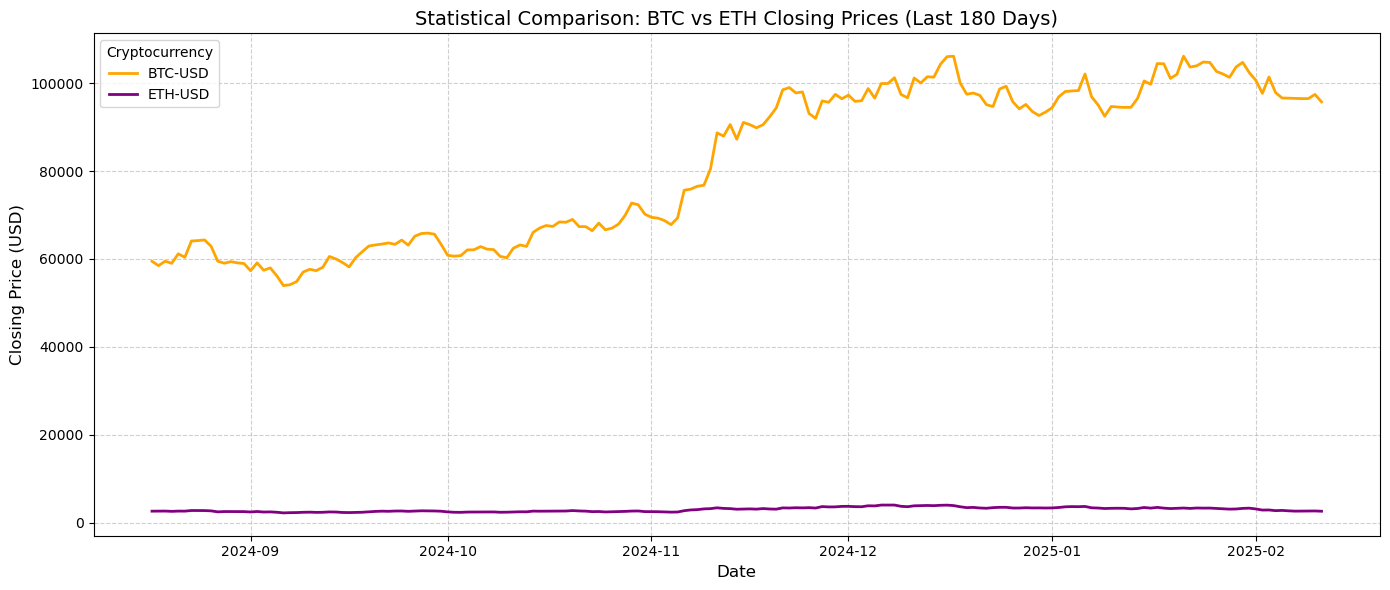

In [69]:
# Step 8.2: Visualize BTC vs ETH Closing Prices (Last 180 Days)

# Extract relevant data for BTC and ETH from last_180 with 'dates' included
btc_close = last_180[last_180['symbol'] == 'BTC-USD'][['dates', 'close']].rename(columns={'close': 'BTC'})
eth_close = last_180[last_180['symbol'] == 'ETH-USD'][['dates', 'close']].rename(columns={'close': 'ETH'})

# Merge on 'dates'
comparison_df = pd.merge(btc_close, eth_close, on='dates')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(comparison_df['dates'], comparison_df['BTC'], label='BTC-USD', color='orange', linewidth=2)
plt.plot(comparison_df['dates'], comparison_df['ETH'], label='ETH-USD', color='purple', linewidth=2)

plt.title('Statistical Comparison: BTC vs ETH Closing Prices (Last 180 Days)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend(title='Cryptocurrency', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Optional: Predictive Modeling

In [71]:
# Step 9: Predictive Modeling with Performance Summary (with optional Positive Growth Filtering)

filter_positive_growth = True  # Set to True to recommend only cryptos with positive predicted growth

predictions = []  # List to store model performance and predictions for each crypto

# Loop through each unique cryptocurrency symbol
for symbol in df['symbol'].unique():
    # Filter and clean data for the current symbol
    symbol_df = df[df['symbol'] == symbol][['dates', 'close']].dropna().copy()

    # Skip symbols with too little data (for model reliability)
    if symbol_df['close'].nunique() < 50 or len(symbol_df) < 100:
        continue

    # Convert dates to number of days since the first date for regression modeling
    symbol_df['days'] = (symbol_df['dates'] - symbol_df['dates'].min()).dt.days
    X = symbol_df[['days']]  # Features
    y = symbol_df['close']   # Target

    try:
        # Split data chronologically into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Train a linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict the price 30 days into the future
        future_day = pd.DataFrame([[symbol_df['days'].max() + 30]], columns=['days'])
        predicted_price = model.predict(future_day)[0]

        # Predict on the test set and evaluate performance
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Calculate growth rate from current to predicted future price
        current_price = y.iloc[-1]
        growth_rate = (predicted_price - current_price) / current_price

        # Store prediction if positive growth is expected or filtering is disabled
        if not filter_positive_growth or growth_rate > 0:
            predictions.append({
                'symbol': symbol,
                'current_price': current_price,
                'predicted_price': predicted_price,
                'growth_rate': growth_rate,
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            })

    except Exception as e:
        continue  # Skip symbols that cause errors (e.g., during model training)

# Create a DataFrame to hold all prediction results
pred_df = pd.DataFrame(predictions)

# If predictions exist, show the top 10 cryptos sorted by model performance (R2 score)
if not pred_df.empty:
    pred_df = pred_df.sort_values(by='R2', ascending=False).head(10)
    title_suffix = " (Positive Growth Only)" if filter_positive_growth else ""
    print(f"\nTop 10 Recommended Cryptocurrencies by Model Performance{title_suffix}:")
    print(pred_df[['symbol', 'current_price', 'predicted_price', 'growth_rate', 'MAE', 'RMSE', 'R2']])


Top 10 Recommended Cryptocurrencies by Model Performance (Positive Growth Only):
             symbol  current_price  predicted_price  growth_rate         MAE  \
333       SUSDE-USD       1.151583         1.167743     0.014032    0.003069   
306        UNFI-USD       0.336828         0.475860     0.412766    0.843185   
11    ZERO31076-USD       0.000110         0.000133     0.205024    0.000034   
140        DUKO-USD       0.000208         0.000326     0.565166    0.000208   
7    BLAST28480-USD       0.004059         0.004739     0.167299    0.001509   
216         HEZ-USD       3.605058         3.822553     0.060330    0.122043   
262        MERL-USD       0.096103         0.125313     0.303935    0.053729   
381       TAIKO-USD       1.049121         1.238912     0.180905    0.167899   
210     JITOSOL-USD     225.270432       240.624095     0.068157   30.517831   
54          ETH-USD    2595.514893      3084.196290     0.188279  508.119174   

           RMSE        R2  
333    0.

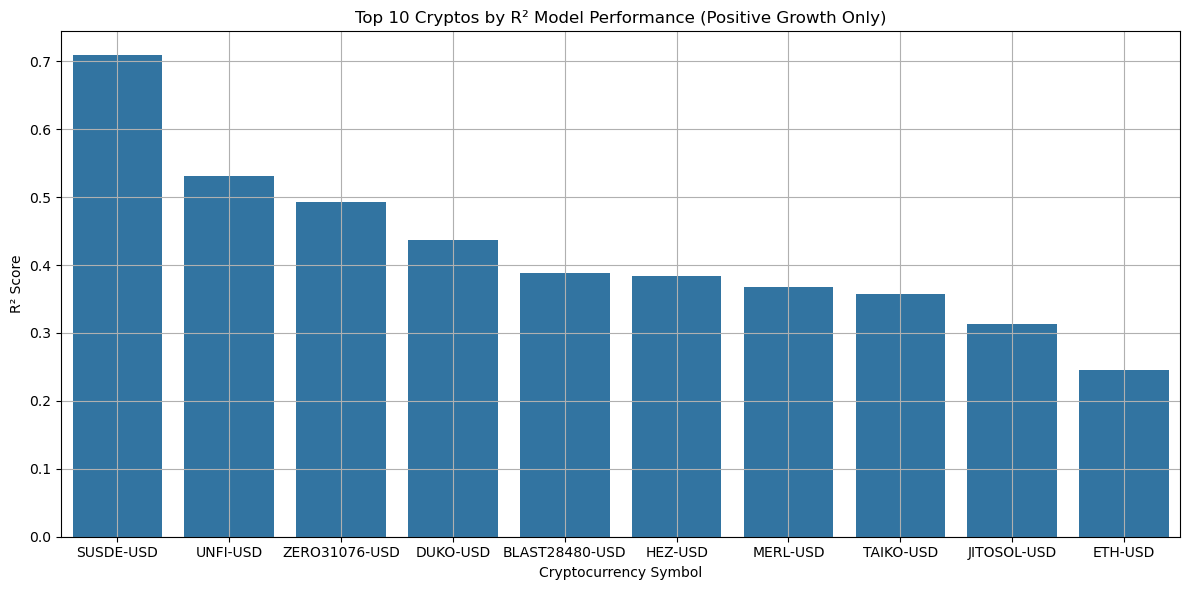

In [72]:
# Step 10: Visualization of Top 10 Models by R² Score (Positive Growth Only)

if not pred_df.empty:
    # Set up the plot size
    plt.figure(figsize=(12, 6))

    # Create a barplot of R² scores by cryptocurrency symbol
    sns.barplot(x='symbol', y='R2', data=pred_df)

    # Add a dynamic title based on the filtering condition
    title_suffix = " (Positive Growth Only)" if filter_positive_growth else ""
    plt.title(f'Top 10 Cryptos by R² Model Performance{title_suffix}')

    # Label axes and improve readability
    plt.ylabel('R² Score')
    plt.xlabel('Cryptocurrency Symbol')
    plt.grid(True)  # Add gridlines for better visual clarity
    plt.tight_layout()  # Optimize layout to avoid clipping
    plt.show()  # Display the plot

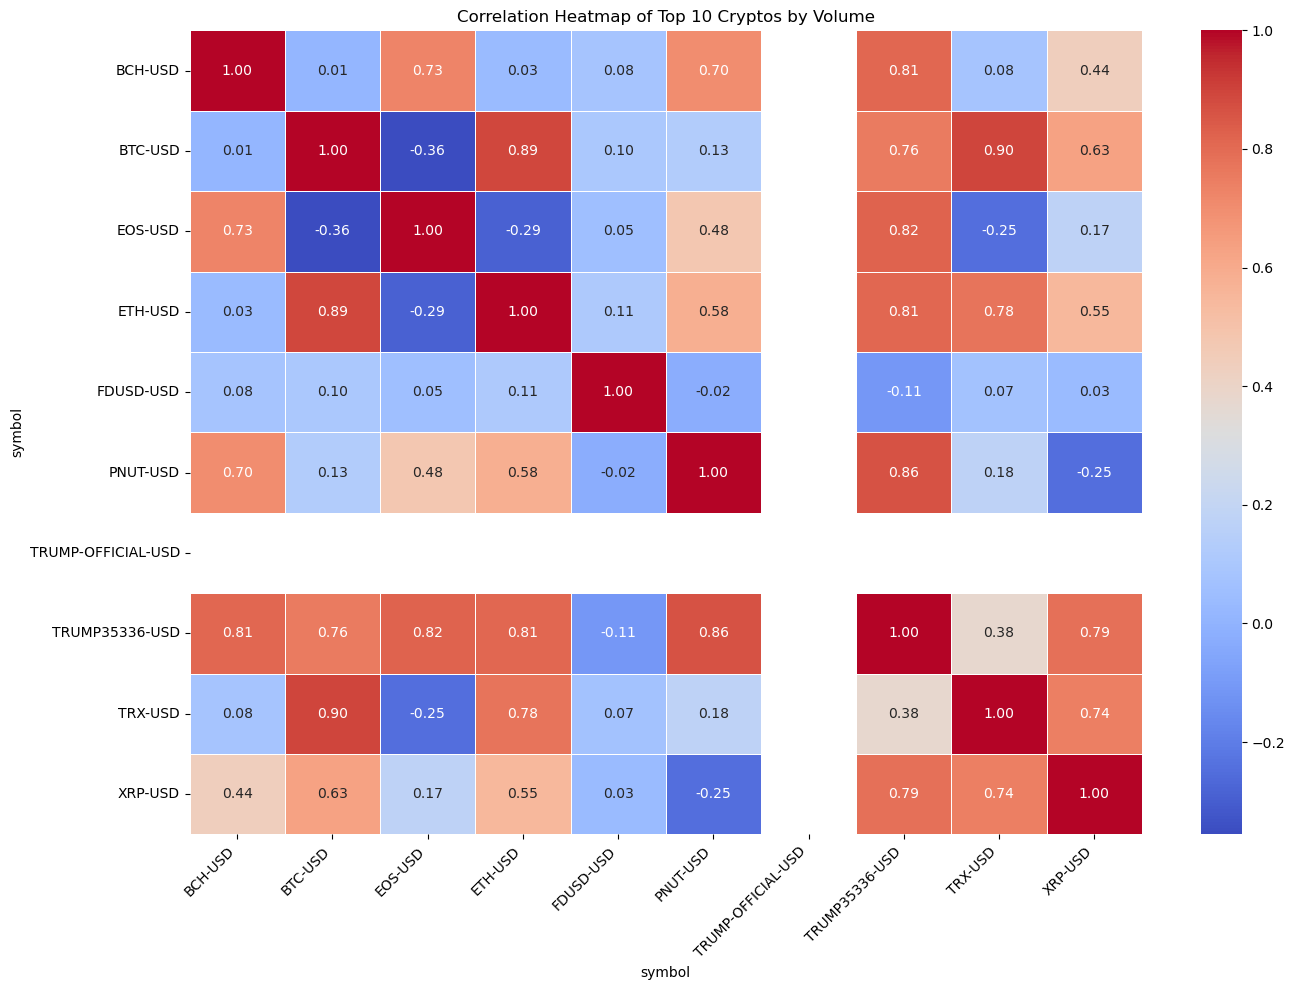

In [73]:
# Step 11: Future Visualization - Correlation Heatmap

# Top 10 symbols by average volume
top_symbols = df.groupby('symbol')['volume'].mean().sort_values(ascending=False).head(10).index

# Filter data
filtered_df = df[df['symbol'].isin(top_symbols)]

# Create pivot table
pivot_df = filtered_df.pivot_table(index='dates', columns='symbol', values='close')

# Correlation matrix
correlation_matrix = pivot_df.corr()

# Plot improved heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Top 10 Cryptos by Volume")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

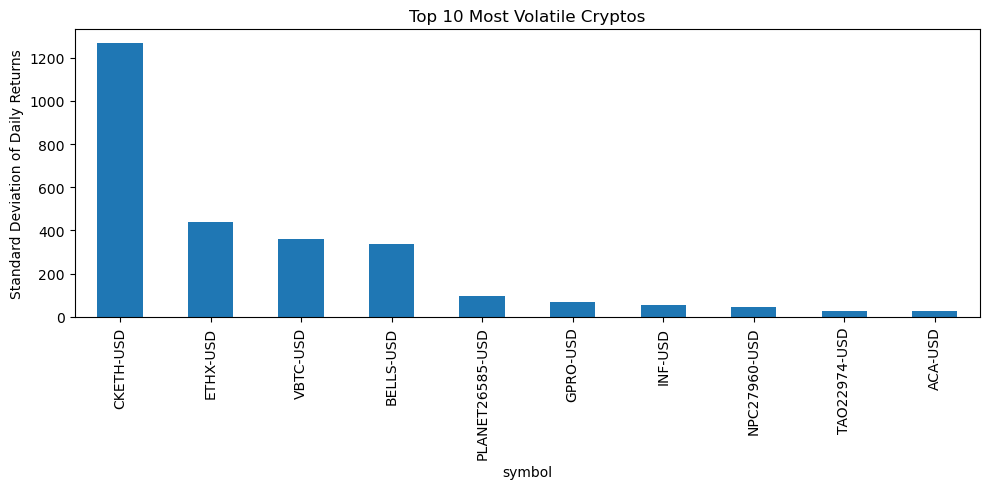

In [74]:
# Step 12: Future Visualization - Volatility Plot (Top 10 Cryptos)
df['daily_return'] = df.groupby('symbol')['close'].pct_change()
volatility = df.groupby('symbol')['daily_return'].std().sort_values(ascending=False).head(10)
volatility.plot(kind='bar', figsize=(10, 5), title='Top 10 Most Volatile Cryptos')
plt.ylabel('Standard Deviation of Daily Returns')
plt.tight_layout()
plt.show()

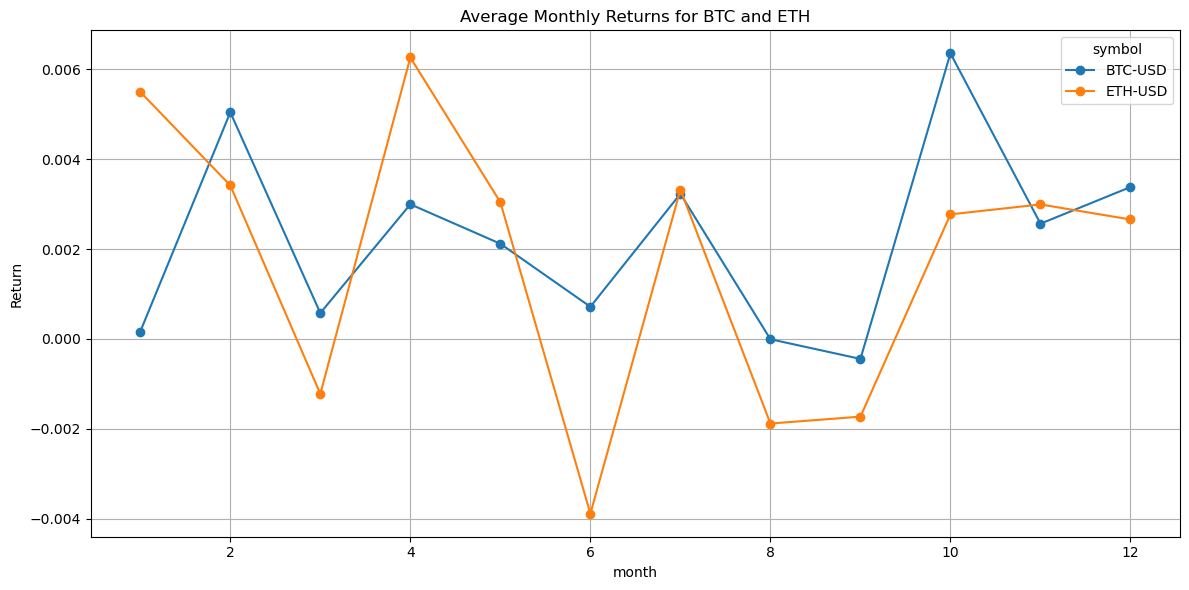

In [75]:
# Step 13: Future Visualization - Monthly Return Comparison for BTC & ETH
df['month'] = df['dates'].dt.month
monthly_returns = df.groupby(['month', 'symbol'])['daily_return'].mean().unstack()
monthly_returns[['BTC-USD', 'ETH-USD']].plot(figsize=(12, 6), marker='o')
plt.title("Average Monthly Returns for BTC and ETH")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()